In [1]:
import cello_multiplier as cm
from onto_lib import general_ontology_tools as got
import pandas as pd

Unable to import pygraphviz. Visualization is disabled.
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\DOID.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\UBERON.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\CL.18-11-13.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\CVCL.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\EFO.17-01-30.obo ...


In [3]:
!pip uninstall cello_multiplier --yes
!pip install -U git+https://github.com/Bishop-Laboratory/CellO-MultiPLIER.git@test

Found existing installation: cello-multiplier 0.0.1
Uninstalling cello-multiplier-0.0.1:
  Successfully uninstalled cello-multiplier-0.0.1
  Cloning https://github.com/Bishop-Laboratory/CellO-MultiPLIER.git (to revision test) to c:\users\julia\appdata\local\temp\pip-req-build-pzqy7t00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for cello-multiplier: filename=cello_multiplier-0.0.1-py3-none-any.whl size=26280814 sha256=86c9b3094f569ef11701cb486ba49225a0586058d338e041c22436e77aa235cf
  Stored in directory: C:\Users\julia\AppData\Local\Temp\pip-ephem-wheel-cache-0n7x1vll\wheels\a3\c6\99\f35157591da3d5ff962e05d55e6b87a15fec53c53d7058a265
Successfully built cello-multiplier


In [2]:
B_df, Z_df, labels, per_gene_mean, per_gene_std, train_dummies_specific, train_dummies_full, classifiers = cm.get_default_mats()

C:\Users\julia\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [3]:
#split 
from pathlib import Path
import json

split_dir = Path('split')



with open(split_dir / 'validation_bulk_experiments.json', 'r') as f:
    validation_egs = json.load(f)

with open(split_dir / 'pre_training_bulk_experiments.json', 'r') as f:
    train_egs = json.load(f)

In [4]:
train_Y_df = B_df[B_df.index.isin(train_egs)]
train_Y_df.shape

(3609, 258)

In [5]:
test_Y_df = B_df[B_df.index.isin(validation_egs)]
test_Y_df.shape

(684, 258)

In [6]:
# create list of samples by celltypes
from sklearn.preprocessing import MultiLabelBinarizer

sample2types = {
            sample: list(map(got.get_term_name, types_ids))
            for sample, types_ids in labels.items()
        }

types_per_b_samples = B_df.index.map(sample2types).values

mlb = MultiLabelBinarizer()
types_per_b_samples = B_df.index.map(sample2types).values

samples_dummies = pd.DataFrame(mlb.fit_transform(types_per_b_samples), columns=mlb.classes_, index=B_df.index)

celltypes = samples_dummies.columns.tolist()

type2samples = {
    type_: samples_dummies.index[samples_dummies[type_] == 1].tolist()
    for type_ in celltypes
}

In [7]:
types_sizes = samples_dummies.sum()
types_sizes

B cell                                             168
Bm4 B cell                                           2
CD14-low, CD16-positive monocyte                    14
CD14-positive monocyte                             302
CD14-positive, CD16-negative classical monocyte     11
                                                  ... 
umbilical artery endothelial cell                    1
unswitched memory B cell                             4
vascular associated smooth muscle cell               5
vein endothelial cell                               67
visceral muscle cell                                 5
Length: 317, dtype: int64

In [8]:
types_sizes.mean()

200.1198738170347

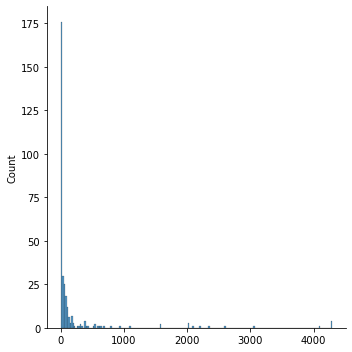

In [9]:
import seaborn as sns
sns.displot(types_sizes)

<AxesSubplot:ylabel='Count'>

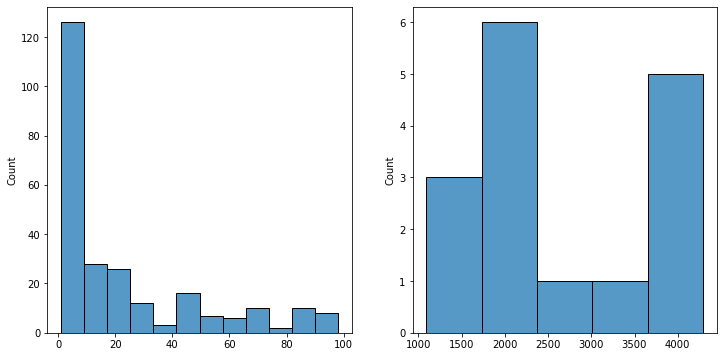

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12, 6))

sns.histplot(types_sizes[types_sizes < 100], ax=ax[0])
sns.histplot(types_sizes[types_sizes > 1000], ax=ax[1])

In [11]:
len(types_sizes)

317

In [94]:
types_sizes[types_sizes < 10]

Bm4 B cell                                2
CD141-positive myeloid dendritic cell     7
CD4-positive, alpha-beta thymocyte        2
CD8-positive, alpha-beta thymocyte        2
IgD-negative memory B cell                1
                                         ..
type II pneumocyte                        5
umbilical artery endothelial cell         1
unswitched memory B cell                  4
vascular associated smooth muscle cell    5
visceral muscle cell                      5
Length: 126, dtype: int64

In [13]:
# create target list for given cell type with 1 being that cell type and 0 being any other cell type
def set_target(celltype, type2samples, train_Y_df, test_Y_df, oversample, max_neg_pos_ratio):
    samplelist = type2samples[celltype]
    samplelist_train = [x for x in samplelist if x in train_Y_df.index.values]
    samplelist_test = [x for x in samplelist if x in test_Y_df.index.values]
    
    if(oversample == True and len(samplelist_train) > 0 and len(samplelist_test) >0):
        len_negative_train = len(train_Y_df)-len(samplelist_train)
        len_positive_train = len(samplelist_train)
        
        neg_pos_ratio = len_negative_train / len_positive_train
        
        # limit the max oversampling ratio
        neg_pos_ratio = min(neg_pos_ratio, max_neg_pos_ratio)
        
        if(neg_pos_ratio > 1):
            df_train = train_Y_df.loc[samplelist_train].sample(
                    n=int((neg_pos_ratio - 1) * len_positive_train),
                    replace=True, random_state=111
                )
            train_Y_df = train_Y_df.append(df_train)
    
    target_train = pd.Series(0,index = train_Y_df.index)
    target_train.loc[samplelist_train] = 1
    
    target_test = pd.Series(0,index = test_Y_df.index)
    target_test.loc[samplelist_test] = 1
    
    train_Y_transformed = train_Y_df
    test_Y_transformed = test_Y_df
    
    return(target_train.values, target_test.values, train_Y_transformed, test_Y_transformed )

In [14]:
def fscore(p, r):
    denom = p + r or 1

    return (p * r) / denom

In [15]:
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
import numpy as np
import warnings
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [16]:
types_with_data = types_sizes.index.values
all_types = samples_dummies.columns


In [110]:
curves =["hematopoietic cell","T cell","granulocyte","epithelial cell","germ line cell"]
def LR_classify(solver,penalty):

    warnings.filterwarnings('ignore') #gets rid of sklearn convergence warning

    successful_celltypes = []
    unsuccessful_celltypes = []
    test_prs = []
    test_precision = []
    test_recall = []
    fscores = []

    for cell_type in tqdm(all_types):
        train_target, train_test, train_data, test_data = set_target(
            cell_type, type2samples, train_Y_df, test_Y_df, oversample=True,
            max_neg_pos_ratio=2
        )

        if(1 in train_target and 1 in train_test and 0 in train_target and 0 in train_test):
            # lasso penalty
            clf = LogisticRegression(solver = solver,penalty = penalty,random_state=111 )

            clf.fit(train_data, train_target)
            target_pred = clf.predict(test_data)
            test_pr = metrics.average_precision_score(train_test, target_pred)
            test_precision += [precision_score(train_test, target_pred)]
            test_recall += [recall_score(train_test, target_pred)]
            fscores += [fscore(test_precision[-1], test_recall[-1])]
            successful_celltypes += [cell_type]
            #plot precision recall curve for celltype
            if(cell_type in curves):
                disp = plot_precision_recall_curve(clf, test_data, train_test)
                disp.ax_.set_title('2-class Precision-Recall curve '+str(cell_type)+': AP={0:0.2f}'.format(test_pr))
        else:
            unsuccessful_celltypes += [cell_type]

    p = np.mean(test_precision)
    r = np.mean(test_recall)
    f = np.mean(fscores)
    f_micro = fscore(p, r) 

    report = pd.DataFrame(list(zip(successful_celltypes,test_precision,test_recall, fscores)),
                          columns = ["celltype","precision score","recall score","f score"])
    print(f'precision: {p:.4f}, recall: {r:.4f}, f1: {f:.4f}, f1 micro avg: {f_micro:.4f}')#
    
    return report


precision: 0.6348, recall: 0.5170, f1: 0.2629, f1 micro avg: 0.2849


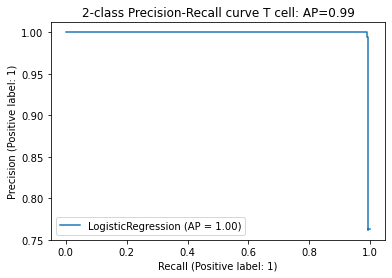

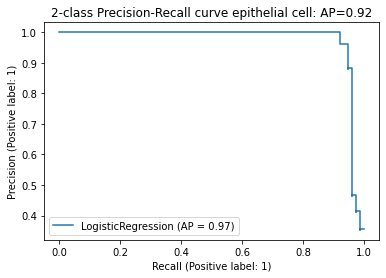

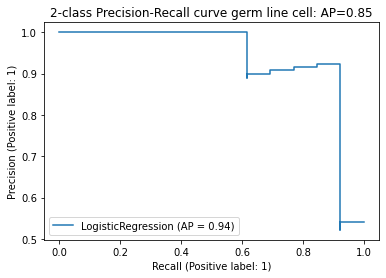

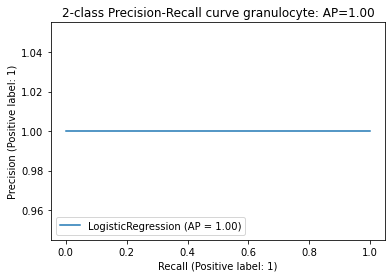

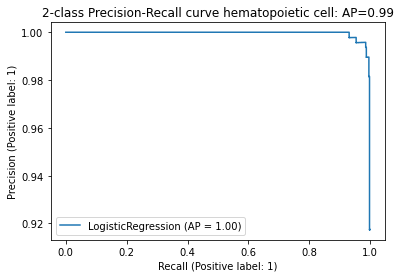

In [111]:
report = LR_classify("liblinear","l1")

In [19]:
report

,celltype,precision score,recall score,f score
0,B cell,0.764706,0.684211,0.361111
1,CD14-positive monocyte,0.724138,0.750000,0.368421
2,"CD14-positive, CD16-negative classical monocyte",0.000000,0.000000,0.000000
3,CD141-positive myeloid dendritic cell,0.000000,0.000000,0.000000
4,CD1c-positive myeloid dendritic cell,1.000000,0.583333,0.368421
...,...,...,...,...
204,type B pancreatic cell,0.666667,1.000000,0.400000
205,type II pneumocyte,0.000000,0.000000,0.000000
206,vascular associated smooth muscle cell,0.000000,0.000000,0.000000
207,vein endothelial cell,0.750000,1.000000,0.428571


In [20]:
def predict_knn(test_data, cell_type):
    prediction = []
    
    
    
    
    
    for name, cell_types in cell_types1.groupby(level=0):
        if(cell_type in cell_types.index.get_level_values(1)):
            pval = cell_types.xs(cell_type, level=1)["p_value"].values[0]
            
            if(pval <= 0.05):
                prediction += [1]
            else:
                prediction += [0]
        else:
            prediction += [0]
    
    return prediction

In [21]:
samplenames = [x for x in range(0,len(test_Y_df))]
normalize = False
most_specific = False
sortby_pval = False
n_neighbours = 5

cell_types1 = cm.classify(
            train_Y_df, 
            test_Y_df,
            samplenames, 
            most_specific, 
            n_neighbours,
            train_dummies_specific,
            train_dummies_full
        )

In [22]:
cell_types1

count  enrichment  \
0   B cell                                             0.0         0.0   
    Bm4 B cell                                         0.0         0.0   
    CD14-low, CD16-positive monocyte                   0.0         0.0   
    CD14-positive monocyte                             0.0         0.0   
    CD14-positive, CD16-negative classical monocyte    0.0         0.0   
...                                                    ...         ...   
683 umbilical artery endothelial cell                  0.0         0.0   
    unswitched memory B cell                           0.0         0.0   
    vascular associated smooth muscle cell             0.0         0.0   
    vein endothelial cell                              0.0         0.0   
    visceral muscle cell                               0.0         0.0   

                                                     p_value  total count  
0   B cell                                               1.0        168.0  
    Bm4 B cell                                           1.0          2.0  
    CD14-low, CD16-positive monocyte                     1.0         14.0  
    CD14-positive monocyte                               1.0        302.0  
    CD14-positive, CD16-negative classical monocyte      1.0         11.0  
...                                                      ...          ...  
683 umbilical artery endothelial cell                    1.0          1.0  
    unswitched memory B cell                             1.0          4.0  
    vascular associated smooth muscle cell               1.0          5.0  
    vein endothelial cell                                1.0         67.0  
    visceral muscle cell                                 1.0          5.0  

[216828 rows x 4 columns]

In [23]:
def KNN_classify():
    
    warnings.filterwarnings('ignore') #gets rid of sklearn convergence warning

    successful_celltypes = []
    unsuccessful_celltypes = []
    test_prs = []
    test_precision = []
    test_recall = []
    fscores = []
    
    
    
    for cell_type in tqdm(all_types):


        train_target, train_test, train_data, test_data = set_target(
            cell_type, type2samples, train_Y_df, test_Y_df, oversample=True,
            max_neg_pos_ratio=2
        )
        
        if(1 in train_target and 1 in train_test and 0 in train_target and 0 in train_test):
            # lasso penalty

            target_pred = predict_knn(test_data.T, cell_type)
            test_pr = metrics.average_precision_score(train_test, target_pred)
            test_precision += [precision_score(train_test, target_pred)]
            test_recall += [recall_score(train_test, target_pred)]
            fscores += [fscore(test_precision[-1], test_recall[-1])]
            successful_celltypes += [cell_type]
            #plot precision recall curve for celltype
            disp = plot_precision_recall_curve(clf, test_data, train_test)
            disp.ax_.set_title('2-class Precision-Recall curve '+str(cell_type)+': AP={0:0.2f}'.format(test_pr))
        else:
            unsuccessful_celltypes += [cell_type]

    p = np.mean(test_precision)
    r = np.mean(test_recall)
    f = np.mean(fscores)
    f_micro = fscore(p, r) 
    
    print(f'precision: {p:.4f}, recall: {r:.4f}, f1: {f:.4f}, f1 micro avg: {f_micro:.4f}')#
    
    report = pd.DataFrame(list(zip(successful_celltypes,test_precision,test_recall, fscores)),
                          columns = ["celltype","precision score","recall score","f score"])
    return report

In [24]:
report1 = KNN_classify()


precision: 0.5731, recall: 0.6554, f1: 0.2727, f1 micro avg: 0.3057


In [25]:
report1


,celltype,precision score,recall score,f score
0,B cell,0.565217,0.684211,0.309524
1,CD14-positive monocyte,0.638889,0.821429,0.359375
2,"CD14-positive, CD16-negative classical monocyte",0.000000,0.000000,0.000000
3,CD141-positive myeloid dendritic cell,1.000000,0.666667,0.400000
4,CD1c-positive myeloid dendritic cell,0.545455,1.000000,0.352941
...,...,...,...,...
204,type B pancreatic cell,0.105263,1.000000,0.095238
205,type II pneumocyte,0.000000,0.000000,0.000000
206,vascular associated smooth muscle cell,1.000000,1.000000,0.500000
207,vein endothelial cell,0.750000,1.000000,0.428571


In [26]:
f_LR = report["f score"]
f_KNN = report1["f score"]
index = report["celltype"]

In [49]:
data = f_LR < f_KNN
data.index = index
data.value_counts()

False    135
True      74
Name: f score, dtype: int64

In [50]:
cellt = data[data == True]
cellt = cellt.index
cellt.tolist()

['CD141-positive myeloid dendritic cell',
 'CD4-positive helper T cell',
 'CD4-positive, CXCR3-negative, CCR6-negative, alpha-beta T cell',
 'CD7-negative lymphoid progenitor OR granulocyte monocyte progenitor',
 'CNS neuron (sensu Vertebrata)',
 'T-helper 2 cell',
 'alveolar macrophage',
 'antibody secreting cell',
 'astrocyte',
 'basal cell of prostate epithelium',
 'bone cell',
 'bone marrow cell',
 'bone marrow hematopoietic cell',
 'central nervous system neuron',
 'contractile cell',
 'conventional dendritic cell',
 'cumulus cell',
 'dendritic cell',
 'dendritic cell, human',
 'ecto-epithelial cell',
 'effector T cell',
 'effector memory CD4-positive, alpha-beta T cell',
 'electrically active cell',
 'electrically responsive cell',
 'electrically signaling cell',
 'endothelial cell',
 'epidermal cell',
 'epithelial cell of lung',
 'epithelial cell of prostate',
 'erythrocyte',
 'erythroid lineage cell',
 'female germ cell',
 'fibroblast',
 'follicular cell of ovary',
 'general ec

In [88]:
diff = (f_KNN - f_LR)
diff.index  = index

In [92]:
diff = diff[data == True].sort_values(ascending = False)
diff

celltype
visceral muscle cell                      0.500000
vascular associated smooth muscle cell    0.500000
oxygen accumulating cell                  0.500000
muscle cell                               0.500000
smooth muscle cell                        0.500000
                                            ...   
myeloid dendritic cell                    0.005495
myeloid dendritic cell, human             0.005495
dendritic cell                            0.005217
alveolar macrophage                       0.002907
bone cell                                 0.002387
Name: f score, Length: 74, dtype: float64

<AxesSubplot:ylabel='celltype'>

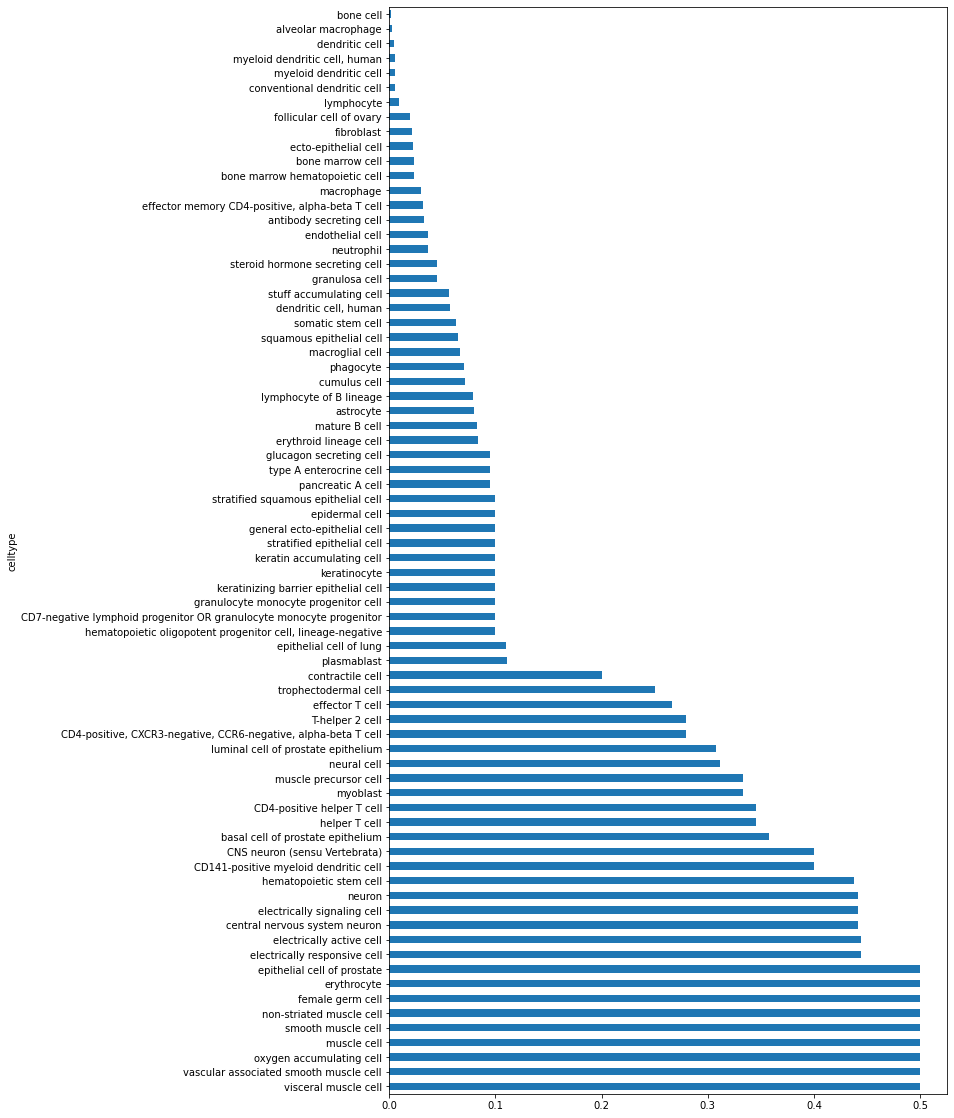

In [93]:
diff.plot.barh(figsize=(10,20))

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
df = pd.concat([f_KNN,f_LR], axis=1)
df.columns = ["f score KNN","f score LR"]
df.index = index
df

,f score KNN,f score LR
celltype,,
B cell,0.309524,0.361111
CD14-positive monocyte,0.359375,0.368421
"CD14-positive, CD16-negative classical monocyte",0.000000,0.000000
CD141-positive myeloid dendritic cell,0.400000,0.000000
CD1c-positive myeloid dendritic cell,0.352941,0.368421
...,...,...
type B pancreatic cell,0.095238,0.400000
type II pneumocyte,0.000000,0.000000
vascular associated smooth muscle cell,0.500000,0.000000


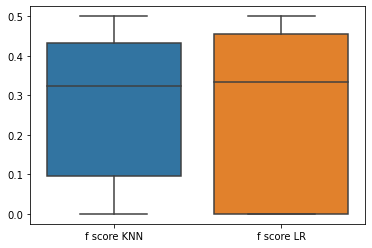

In [109]:
sns.boxplot( data=df)

plt.show()